In [1]:
%matplotlib nbagg
%load_ext line_profiler
%load_ext autoreload

In [2]:
import math

import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
import scipy.sparse
import sparse
import numba

In [3]:
from libertem import api
from libertem.executor.inline import InlineJobExecutor
from libertem.executor.base import AsyncAdapter
from libertem.udf.backend import set_use_cuda, set_use_cpu, get_backend
from libertem.udf.base import UDFRunner, UDF
from libertem.common.container import MaskContainer
from libertem.masks import circular
from libertem.corrections.coordinates import identity

In [4]:
from ptychography.reconstruction.ssb import SSB_UDF, generate_masks
from ptychography.reconstruction.ssb_lowmem import generate_masks as generate_lowmem, SSB_UDF as SSB_lowmem_UDF
from ptychography.reconstruction.ssb_lowmem import mask_tile_pair
from ptychography.reconstruction.common import wavelength, get_shifted

In [5]:
executor = InlineJobExecutor()
ctx = api.Context(executor=executor)
async_executor = AsyncAdapter(executor)
# ctx = api.Context()

In [6]:
# set_use_cuda(0)
set_use_cpu(0)

In [ ]:
ctx.executor.client.scheduler_info()

In [ ]:
def reference_ssb(data, U, dpix, semiconv, semiconv_pix, cy=None, cx=None):

    # 'U' - The acceleration voltage U in keV
    # 'dpix' - STEM pixel size in m
    # 'semiconv' -  STEM semiconvergence angle in radians
    # 'semiconv_pix' - Diameter of the primary beam in the diffraction pattern in pixels

    reordered = np.moveaxis(data, (0, 1), (2, 3))
    ffts = np.fft.fft2(reordered)
    rearranged_ffts = np.moveaxis(ffts, (2, 3), (0, 1))

    Nblock = np.array(data.shape[0:2])
    Nscatter = np.array(data.shape[2:4])

    # electron wavelength in m
    lamb = wavelength(U)
    # spatial freq. step size in scattering space
    d_Kf = np.sin(semiconv)/lamb/semiconv_pix
    # spatial freq. step size according to probe raster
    d_Qp = 1/dpix/Nblock

    result_f = np.zeros(data.shape[:2], dtype=rearranged_ffts.dtype)

    masks = np.zeros_like(data)

    if cx is None:
        cx = data.shape[-1] / 2
    if cy is None:
        cy = data.shape[-2] / 2

    y, x = np.ogrid[0:Nscatter[0], 0:Nscatter[1]]
    filter_center = circular(
        centerX=cx, centerY=cy,
        imageSizeX=Nscatter[1], imageSizeY=Nscatter[0],
        radius=semiconv_pix,
        antialiased=True
    ).astype(np.float64)

    for row in range(Nblock[0]):
        for column in range(Nblock[1]):
            qp = np.array((row, column))
            flip = qp > Nblock / 2
            real_qp = qp.copy()
            real_qp[flip] = qp[flip] - Nblock[flip]

            sy, sx = real_qp * d_Qp / d_Kf

            filter_positive = circular(
                centerX=cx+sx, centerY=cy+sy,
                imageSizeX=Nscatter[1], imageSizeY=Nscatter[0],
                radius=semiconv_pix,
                antialiased=True
            ).astype(np.float64)

            filter_negative = circular(
                centerX=cx-sx, centerY=cy-sy,
                imageSizeX=Nscatter[1], imageSizeY=Nscatter[0],
                radius=semiconv_pix,
                antialiased=True
            ).astype(np.float64)
            mask_positive = filter_center * filter_positive * (filter_negative == 0)
            mask_negative = filter_center * filter_negative * (filter_positive == 0)

            non_zero_positive = mask_positive.sum()
            non_zero_negative = mask_negative.sum()

            f = rearranged_ffts[row, column]

            if non_zero_positive >= 1 and non_zero_negative >= 1:
                tmp = ((f * mask_positive).sum() / non_zero_positive - (f * mask_negative).sum() / non_zero_negative) / 2
                result_f[row, column] = tmp
                masks[row, column] = ((mask_positive / non_zero_positive) - (
                               mask_negative / non_zero_negative)) / 2
                assert np.allclose(result_f[row, column], (f*masks[row, column]).sum())
            else:
                assert non_zero_positive < 1
                assert non_zero_negative < 1

    result_f[0, 0] = (rearranged_ffts[0, 0] * filter_center).sum() / filter_center.sum()
    masks[0, 0] = filter_center / filter_center.sum()

    return result_f, masks

In [ ]:
path = r'/cachedata/users/weber/data/CBED_MSAP.raw.transposed'
dtype = np.float64

shape = (50, 50, 189, 189)
#  ? shape = np.random.uniform(1, 300, (4,1,))

reconstruct_shape = shape[:2]

# The acceleration voltage U in keV
U = 300
# STEM pixel size in m, here 50 STEM pixels on 0.5654 nm
dpix = 0.5654/50*1e-9
# STEM semiconvergence angle in radians
semiconv = 25e-3
# Diameter of the primary beam in the diffraction pattern in pixels
semiconv_pix = 78.6649
transformation = identity()

cy = 189 // 2
cx = 189 // 2

In [ ]:
input_data = np.memmap(path, dtype=np.float32, shape=shape, mode='r', order='C')

In [ ]:
ds = ctx.load("raw", path=path, dtype=np.float32, scan_size=shape[:2], detector_size=shape[2:])

In [7]:
dtype = np.float64
scale = 4
shape = (66, 55, 189 // scale, 190 // scale)
reconstruct_shape = (shape[0], shape[1])
#  ? shape = np.random.uniform(1, 300, (4,1,))

# The acceleration voltage U in keV
U = 300
# STEM pixel size in m, here 50 STEM pixels on 0.5654 nm
dpix = 0.5654/50*1e-9 
# STEM semiconvergence angle in radians
semiconv = 25e-3
# Diameter of the primary beam in the diffraction pattern in pixels
semiconv_pix = 78.6649 / scale

transformation = identity()

cy = 91 // scale
cx = 95 // scale

In [8]:
shape

(66, 55, 47, 47)

In [9]:
input_data = np.random.uniform(0, 1, shape)

In [10]:
ds = ctx.load("memory", data=input_data)

In [ ]:
%%time
result_f, reference_masks = reference_ssb(input_data, U, dpix, semiconv, semiconv_pix, cy, cx)

In [144]:
%%time
%autoreload

masks = generate_lowmem(
    reconstruct_shape=reconstruct_shape,
    mask_shape=shape[2:],
    dtype=dtype,
    wavelength=wavelength(U),
    dpix=dpix,
    semiconv=semiconv,
    semiconv_pix=semiconv_pix,
    center=(cy, cx),
    transformation=transformation,
    cutoff=15
)

mask_container = MaskContainer(
    mask_factories=lambda: masks, dtype=masks.dtype,
    use_sparse='scipy.sparse.csc', count=masks.shape[0], backend=get_backend(),
)

Mask factory size 7895580 larger than warning limit 1048576, may be inefficient


CPU times: user 191 ms, sys: 2.99 ms, total: 194 ms
Wall time: 193 ms


In [ ]:
def test():    
    masks = generate_masks(
        reconstruct_shape=reconstruct_shape,
        mask_shape=shape[2:],
        dtype=dtype,
        wavelength=wavelength(U),
        dpix=dpix,
        semiconv=semiconv,
        semiconv_pix=semiconv_pix,
        center=(cy, cx),
        angle=angle,
    )

%lprun -f generate_masks -f mask_tile_pair -f get_shifted test()


In [ ]:
fig, axes = plt.subplots(2, 2)
r = reference_masks[:shape[0]//2 + 1]
m = masks.reshape((shape[0]//2 + 1, shape[1], shape[2], shape[3]))
axes[0, 0].imshow(np.abs(r- m).sum(axis=(0, 1)))
axes[0, 1].imshow(np.abs(r - m).sum(axis=(2, 3)))
axes[1, 0].imshow((r[8,12] - m[8, 12]))
axes[1, 1].imshow(r[8,12])

In [11]:
def test():
    masks = generate_lowmem(
        reconstruct_shape=reconstruct_shape,
        mask_shape=shape[2:],
        dtype=dtype,
        wavelength=wavelength(U),
        dpix=dpix,
        semiconv=semiconv,
        semiconv_pix=semiconv_pix,
        center=(cy, cx),
        transformation=transformation,
    )
%lprun -f mask_tile_pair -f generate_lowmem test()

/cachedata/users/weber/ptychography-venv/lib/python3.6/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/cachedata/users/weber/ptychography-venv/lib/python3.6/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.targets.imputils', please update to use 'numba.core.imputils' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/cachedata/users/weber/ptychography-venv/lib/python3.6/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'impl_ret_borrowed' requested from: '

In [145]:
%autoreload
udf = SSB_UDF(
    U=U, dpix=dpix, semiconv=semiconv, semiconv_pix=semiconv_pix,
    dtype=dtype, center=(cy, cx), transformation=transformation,
    mask_container=mask_container, cutoff=15
)

In [146]:
%%time
udf_result = ctx.run_udf(udf=udf, dataset=ds)

CPU times: user 683 ms, sys: 1.91 ms, total: 685 ms
Wall time: 682 ms


In [147]:
%autoreload
udf_lowmem = SSB_lowmem_UDF(
    U=U, dpix=dpix, semiconv=semiconv, semiconv_pix=semiconv_pix,
    dtype=dtype, center=(cy, cx), transformation=transformation,
    cutoff=15
)

In [148]:
%%time
udf_result_lowmem = ctx.run_udf(udf=udf_lowmem, dataset=ds)

Mask factory size 7895758 larger than warning limit 1048576, may be inefficient
Mask factory size 7895758 larger than warning limit 1048576, may be inefficient
Mask factory size 7895758 larger than warning limit 1048576, may be inefficient
Mask factory size 7895758 larger than warning limit 1048576, may be inefficient
Mask factory size 7895758 larger than warning limit 1048576, may be inefficient
Mask factory size 7895758 larger than warning limit 1048576, may be inefficient
Mask factory size 7895758 larger than warning limit 1048576, may be inefficient
Mask factory size 7895758 larger than warning limit 1048576, may be inefficient
Mask factory size 7895758 larger than warning limit 1048576, may be inefficient
Mask factory size 7895758 larger than warning limit 1048576, may be inefficient
Mask factory size 7895758 larger than warning limit 1048576, may be inefficient
Mask factory size 7895758 larger than warning limit 1048576, may be inefficient
Mask factory size 7895758 larger than wa

CPU times: user 35.5 s, sys: 7.55 ms, total: 35.5 s
Wall time: 35.4 s


In [149]:
np.max(np.abs(udf_result_lowmem["pixels"].data - udf_result["pixels"].data))

4.547473508864641e-13

<IPython.core.display.Javascript object>


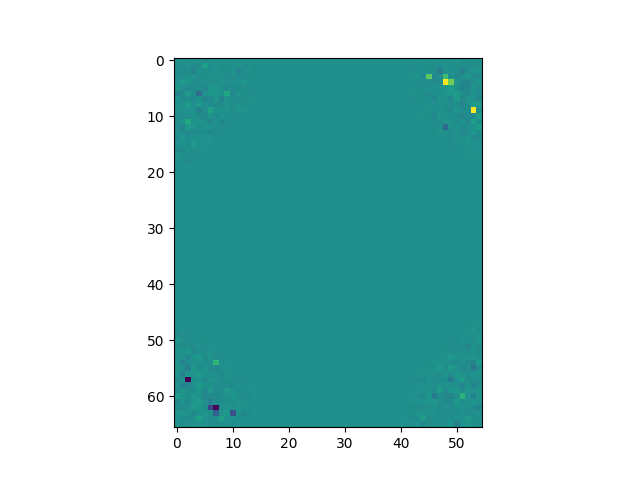

In [150]:
fig, axes = plt.subplots()
axes.imshow(np.angle(udf_result_lowmem["pixels"]) - np.angle(udf_result["pixels"]))

In [ ]:
np.allclose(reference_masks[:shape[0]//2 + 1], masks.reshape((shape[0]//2 + 1, shape[1], shape[2], shape[3])).todense())

In [ ]:
np.allclose(result_f, udf_result["pixels"])

In [ ]:
np.max(np.abs(result_f - udf_result["pixels"]))

In [ ]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(np.angle(np.fft.ifft2(result_f)))
axes[0, 1].imshow(np.angle(np.fft.ifft2(udf_result["pixels"])))
axes[1, 0].imshow(np.angle(np.fft.ifft2(udf_result["pixels"])) - np.angle(np.fft.ifft2(result_f)))

In [ ]:
np.allclose(udf_result['pixels'].data, result_f)

In [ ]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(np.abs(reference_masks[:shape[0]//2 + 1] - masks.reshape((shape[0]//2 + 1, shape[1], shape[2], shape[3]))).sum(axis=(0, 1)))
axes[0, 1].imshow(np.abs(reference_masks[:shape[0]//2 + 1] - masks.reshape((shape[0]//2 + 1, shape[1], shape[2], shape[3]))).sum(axis=(2, 3)))
axes[1, 0].imshow((reference_masks[:shape[0]//2 + 1][8,12] - masks.reshape((shape[0]//2 + 1, shape[1], shape[2], shape[3]))[8, 12]))
axes[1, 1].imshow(reference_masks[:shape[0]//2 + 1][8,12])

In [ ]:
%lprun -f generate_masks -f SSB_UDF.get_task_data -f SSB_UDF.process_tile ctx.run_udf(udf=udf, dataset=ds)

In [ ]:
fig, axes = plt.subplots(2)
axes[0].imshow(np.imag(result_f))
axes[1].imshow(np.imag(udf_result['pixels'].data))

In [ ]:
mask_stack = reference_masks[:shape[0] // 2 + 1].reshape((-1, shape[2]*shape[3])).T.copy()


def simple_test(roi, data):
    tiledepth = 23
    num_tiles = len(data) // tiledepth
    result = np.zeros(shape[:2], dtype=np.complex128)

    y_positions, x_positions = np.mgrid[0:shape[0], 0:shape[1]]
    y_map = y_positions[roi]
    x_map = x_positions[roi]
    
    
    half_y = shape[0] // 2 + 1
    
    q_steps = -2j*np.pi*np.linspace(0, 1, shape[0], endpoint=False)[:half_y]
    p_steps = -2j*np.pi*np.linspace(0, 1, shape[1], endpoint=False)
    
    def process_tile(tile, tile_start):
        tile_depth = tile.shape[0]
        y_indices = y_map[tile_start:tile_start+tile_depth]
        x_indices = x_map[tile_start:tile_start+tile_depth]
        
        dot_result = np.dot(tile.reshape(tile_depth, -1), mask_stack).reshape((tile_depth, half_y, shape[1]))
        fourier_factors_q = np.exp(y_indices[:, np.newaxis, np.newaxis] * q_steps[np.newaxis, :, np.newaxis])
        fourier_factors_p = np.exp(x_indices[:, np.newaxis, np.newaxis] * p_steps[np.newaxis, np.newaxis, :])
        
        buffer_frame = np.zeros_like(result)
        buffer_frame[:half_y] = (dot_result*fourier_factors_q*fourier_factors_p).sum(axis=0)
        # Account for even and odd sizes
        # FIXME make sure this is correct using an example that transmits also the high spatial frequencies
        patch = (shape[0]) % 2
        # We skip the first row since it would be outside the FOV
        extracted = buffer_frame[1:shape[0] // 2 + patch]
        # The coordinates of the bottom half are inverted and
        # the zero column is rolled around to the front
        # The real part is inverted
        buffer_frame[shape[0] // 2 + 1:] = -np.conjugate(np.roll(np.flip(extracted), shift=1, axis=1))
        return buffer_frame
    
    for tile in range(num_tiles):
        start = tile*tiledepth
        tile = data[start:start+tiledepth]
        result += process_tile(tile, start)
    remaining_tile = data[num_tiles*tiledepth:]
    result += process_tile(remaining_tile, num_tiles*tiledepth)
            
    return result

In [ ]:
%%time
roi_1 = np.random.choice([True, False], shape[:2])
roi_2 = np.invert(roi_1)

roi_all = np.ones(shape[:2], dtype=bool)
result = simple_test(roi_1, input_data[roi_1]) + simple_test(roi_2, input_data[roi_2])
# result = simple_test(roi_all, input_data[roi_all])

In [ ]:
np.allclose(result_f, result)

In [ ]:
fig, axes = plt.subplots(2, 3)
axes[0, 0].imshow(np.real(result_f), vmin=-5, vmax=5)
axes[0, 1].imshow(np.real(result), vmin=-5, vmax=5)
axes[0, 2].imshow(np.real(result - result_f))
axes[1, 0].imshow(np.imag(result_f))
axes[1, 1].imshow(np.imag(result))
axes[1, 2].imshow(np.imag(result - result_f))


In [ ]:
path_real = r'/cachedata/users/clausen/SSB-Data/stuff.raw'
dtype = np.float32

scan_size = (256,256)
detector_size = (66, 66)


params = {
    "dpix": 0.0153e-9,
    "center": (32.67, 34.08),
    "semiconv": 24.8e-3,
    "semiconv_pix": 25.99,
    "dtype": np.float32,
#     "angle": 302.0,
    "angle": 0,  # best so far
#     "angle": 10,
#     "angle": 30,
    "cutoff": 15,
}

U = 80

In [ ]:
ds_real = ctx.load('RAW', path=path_real, scan_size=scan_size, detector_size=detector_size, dtype=np.float32)
ds_real._cores = 18

In [ ]:
%autoreload
masks = generate_masks(
    **params,
    reconstruct_shape=scan_size,
    wavelength=wavelength(U),
    mask_shape=detector_size,
)

mask_container = MaskContainer(
    mask_factories=lambda: masks, dtype=masks.dtype,
    use_sparse='scipy.sparse.csr', count=masks.shape[0], backend=get_backend()
)

In [ ]:
%autoreload
udf = SSB_UDF(
    U=U, **params,
    mask_container=mask_container,
)

In [ ]:

# plt.figure()

# im_obj = None

# udfres_iter = UDFRunner(udf).run_for_dataset_async(dataset=ds_real, executor=async_executor, cancel_id="whatever")
# async for udf_results in udfres_iter:
#     data = np.angle(np.fft.ifft2(udf_results['pixels']))
#     if im_obj is None:
#         im_obj = plt.imshow(data)
#     else:
#         im_obj.set_data(data)
#     im_obj.autoscale()
#     im_obj.norm.vmin = np.min(data[data!=0])
#     im_obj.norm.vmax = np.max(max(1, np.max(data[data!=0])))
#     im_obj.changed()
#     im_obj.figure.canvas.draw()

In [ ]:
udf_real = ctx.run_udf(udf=udf, dataset=ds_real, progress=True)

In [ ]:
fig, axes = plt.subplots()
y, x = np.meshgrid(np.linspace(-1, 1, 256, endpoint=False), np.linspace(-1, 1, 256, endpoint=False))
d = np.sqrt(x**2 + y**2)
bandpass = d*256 < 85
# sigma, mu = 0.1, 0.0
# bandpass = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
# bandpass += 0.3
# bandpass[bandpass>1] = 1
# axes.imshow(bandpass.astype(np.float32))
# axes.imshow(d)
# axes.imshow(np.fft.fftshift(bandpass))
# axes.imshow(bandpass * np.abs(np.fft.fftshift(udf_real["pixels"])), vmin=0, vmax=3.3e4)
# axes.imshow(np.angle(np.fft.fftshift(udf_real["pixels"])))
# axes.imshow(np.angle(np.fft.ifft2(np.fft.fftshift(bandpass)*udf_real["pixels"])))
# axes.imshow(np.angle(np.fft.ifft2(np.fft.fftshift(np.invert(bandpass))*udf_real["pixels"])))
axes.imshow(np.abs(np.invert(bandpass)*np.fft.fftshift(udf_real["pixels"])))
# axes.imshow(np.angle(np.fft.ifft2(udf_real["pixels"])))

In [ ]:
# a = ctx.create_pick_analysis(dataset=ds_real, y=127, x=127)
# pick_res = ctx.run(a)

In [ ]:
m = masks[3*256].todense()

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(pick_res["intensity"].raw_data*m + pick_res["intensity"].raw_data/1000)
axes[1].imshow(m)

In [ ]:
path_empad = r'/cachedata/users/weber/acquisition_12.xml'
dtype = np.float32

scan_size_empad = (256,256)
detector_size_empad = (128, 128)


params_empad = {
    "dpix": 22*250e-12/256,
    "center": (64, 64),
    "semiconv": 24.8e-3,
    "semiconv_pix": 25,
    "dtype": np.float32,
    "cutoff": 15,
    "angle": 0,
}

U_empad = 300

In [ ]:
ds_empad = ctx.load('EMPAD', path=path_empad, scan_size=scan_size_empad)
ds_empad._cores=128

In [ ]:
%autoreload
masks_empad = generate_masks(
    **params_empad,
    reconstruct_shape=scan_size_empad,
    wavelength=wavelength(U_empad),
    mask_shape=detector_size_empad,
)

mask_container_empad = MaskContainer(
    mask_factories=lambda: masks_empad, dtype=masks_empad.dtype,
    use_sparse='scipy.sparse.csr', count=masks_empad.shape[0], backend=get_backend()
)

In [ ]:
%autoreload
udf_empad = SSB_UDF(
    U=U_empad, **params_empad,
    mask_container=mask_container_empad,
)

In [ ]:
ds_empad.shape

In [ ]:
udf_res_empad = ctx.run_udf(udf=udf_empad, dataset=ds_empad, progress=True)

In [ ]:
fig, axes = plt.subplots()
axes.imshow(np.angle(np.fft.ifft2(udf_res_empad["pixels"])))

In [ ]:
a = np.array(([1, 2, 3, 4, 5], [6, 7, 8, 9, 10]))

In [ ]:
s = (slice(1, 2), slice(1, 2))

In [ ]:
a[s]

In [ ]:
%autoreload
class DebugUDF(UDF):
    def process_tile(self, tile):
#         print(self.meta.tiling_scheme)
#         print(tile.scheme_idx)
#         print(tile.tile_slice)
        pass
        
    def get_result_buffers(self):
        return {}
    
    def get_task_data(self):
        print(self.meta.tiling_scheme)


In [ ]:
ctx.run_udf(udf=DebugUDF(), dataset=ds)